In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('/mnt/c/Ryan_Data/Python_Tool/ryan_mplstyle.mplstyle')

import numpy as np

import h5py
import cmocean.cm as cmo
import dedalus.public as d3

from scipy import special

In [2]:
# Parameters
Ly, Lz = 16, 1
Ny, Nz = 512, 16

dealias = 3/2
dtype = np.float64

Ro = 0.3

In [3]:
# Bases
coords = d3.CartesianCoordinates('y', 'z')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.Chebyshev(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)
zbasis = d3.Chebyshev(coords['z'], size=Nz, bounds=(-Lz/2, Lz/2), dealias=dealias)

In [4]:
# Substitutions
dy = lambda A: d3.Differentiate(A, coords['y'])
dz = lambda A: d3.Differentiate(A, coords['z'])

y, z = dist.local_grids(ybasis, zbasis)

lift_basisy = ybasis.derivative_basis(2)
lifty = lambda A, n: d3.Lift(A, lift_basisy, n)
lift_basisz = zbasis.derivative_basis(2)
liftz = lambda A, n: d3.Lift(A, lift_basisz, n)

In [5]:
Lz = 1

dealias = 3/2
timestepper = d3.RK111
dtype = np.float64
nu = 0

Ro = 0.3

# Bases
coords = d3.CartesianCoordinates('y', 'z')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.Chebyshev(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)
zbasis = d3.Chebyshev(coords['z'], size=Nz, bounds=(-Lz/2, Lz/2), dealias=dealias)

# Substitutions
dy = lambda A: d3.Differentiate(A, coords['y'])
dz = lambda A: d3.Differentiate(A, coords['z'])

y, z = dist.local_grids(ybasis, zbasis)

lift_basisy = ybasis.derivative_basis(2)
lifty = lambda A, n: d3.Lift(A, lift_basisy, n)
lift_basisz = zbasis.derivative_basis(2)
liftz = lambda A, n: d3.Lift(A, lift_basisz, n)

# Fields
q = dist.Field(name='q', bases=(ybasis,zbasis))

P0 = dist.Field(name='P0', bases=(ybasis,zbasis))
tau_y1 = dist.Field(name='tau_y1', bases=zbasis)
tau_y2 = dist.Field(name='tau_y2', bases=zbasis)
tau_z1 = dist.Field(name='tau_z1', bases=ybasis)
tau_z2 = dist.Field(name='tau_z2', bases=ybasis)
tau_P0 = dist.Field(name='tau_P0')

P1 = dist.Field(name='P1', bases=(ybasis,zbasis))
tau_P1y1 = dist.Field(name='tau_P1y1', bases=zbasis)
tau_P1y2 = dist.Field(name='tau_P1y2', bases=zbasis)
tau_P1z1 = dist.Field(name='tau_P1z1', bases=ybasis)
tau_P1z2 = dist.Field(name='tau_P1z2', bases=ybasis)
tau_P1 = dist.Field(name='tau_P1')

G = dist.Field(name='G', bases=(ybasis,zbasis))
tau_Gy1 = dist.Field(name='tau_Gy1', bases=zbasis)
tau_Gy2 = dist.Field(name='tau_Gy2', bases=zbasis)
tau_Gz1 = dist.Field(name='tau_Gz1', bases=ybasis)
tau_Gz2 = dist.Field(name='tau_Gz2', bases=ybasis)

bt = dist.Field(name='bt', bases=ybasis)
bb = dist.Field(name='bb', bases=ybasis)

u = dist.Field(name='u', bases=(ybasis,zbasis))
b = dist.Field(name='b', bases=(ybasis,zbasis))
zeta = dist.Field(name='zeta', bases=(ybasis,zbasis))

C0 = dist.Field()
C1 = dist.Field()
D = dist.Field()

# Substitution
Q2 = lambda A: dy(dz(A))
dyy = lambda A: dy(dy(A))

In [6]:
# Problem
problem = d3.IVP([P0, tau_z1, tau_z2, tau_y1, tau_y2, C0, \
                  G, tau_Gz1, tau_Gz2, tau_Gy1, tau_Gy2, \
                  P1, tau_P1z1, tau_P1z2, tau_P1y1, tau_P1y2, C1, \
                  u, zeta, b
                 ], namespace=locals())

problem.add_equation("lap(P0) + liftz(tau_z1,-1) + liftz(tau_z2,-2)  + lifty(tau_y1,-1) + lifty(tau_y2,-2) - C0 = 0")
problem.add_equation("integ(P0) = 0")
problem.add_equation("dz(P0)(z=Lz/2) = bt-D")
problem.add_equation("dz(P0)(z=-Lz/2) = bb+D")
problem.add_equation("dy(P0)(y=-Ly/2) = 0")
problem.add_equation("dy(P0)(y=Ly/2) = 0")

problem.add_equation("lap(G) + liftz(tau_Gz1,-1) + liftz(tau_Gz2,-2)  + lifty(tau_Gy1,-1) + lifty(tau_Gy2,-2) -2*Q2(P0) = 0")
problem.add_equation("G(z=-Lz/2) = 0")
problem.add_equation("G(z=Lz/2) = 0")
problem.add_equation("G(y=-Ly/2) = 0")
problem.add_equation("G(y=Ly/2) = 0")

problem.add_equation("lap(P1) + liftz(tau_P1z1,-1) + liftz(tau_P1z2,-2)  + lifty(tau_P1y1,-1) + lifty(tau_P1y2,-2) - C1/Ro = -( dyy(P0)*dz(dz(P0))-dy(dz(P0))**2 )")
problem.add_equation("integ(P1) = 0")
problem.add_equation("dz(P1)(z=Lz/2) = D/Ro")
problem.add_equation("dz(P1)(z=-Lz/2) = -D/Ro")
problem.add_equation("dy(P1)(y=-Ly/2) = 0")
problem.add_equation("dy(P1)(y=Ly/2) = 0")

problem.add_equation("u = -(dy(P0)+Ro*dy(P1))")
problem.add_equation("zeta = -dy(u)")
problem.add_equation("b = dz(P0)+Ro*dz(P1)")

{'LHS': <Field 139668953608352>,
 'RHS': Add(Diff(<Field 139668953267888>), Mul(0.3, Diff(<Field 139668953611280>))),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('float64'),
 'M': 0,
 'L': Convert(<Field 139668953608352>),
 'F': Add(Diff(<Field 139668953267888>), Mul(0.3, Diff(<Field 139668953611280>))),
 'domain': <dedalus.core.domain.Domain at 0x7f07365dbfa0>,
 'matrix_dependence': array([False,  True]),
 'matrix_coupling': array([False,  True])}

In [7]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = 1

2023-12-10 15:16:11,200 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


In [8]:
D_lr = [-1,1]
res_lr = [1.39161683,-1.40838317]
res_new = 1e100

while abs(res_new) >1e-13:
    q.change_scales(1)
    bt.change_scales(1)
    bb.change_scales(1)

    q['g'] = 0
    bt['g'] = -special.erf(1.0*y)
    bb['g'] = -special.erf(1.0*y)

    # D['g'] = -0.00599
    D['g'] = (D_lr[0]+D_lr[1])/2

    ###
    solver.step(1e-10); solver.step(1e-10); solver.step(1e-10)

    res_new=C0['g']+Ro*C1['g']
    print(res_new)
    
    if res_new*res_lr[0]<0:
        D_lr[1] = (D_lr[0]+D_lr[1])/2
    else:
        D_lr[0] = (D_lr[0]+D_lr[1])/2

[[-0.00838317]]
[[0.69161683]]
[[0.34161683]]
[[0.16661683]]
[[0.07911683]]
[[0.03536683]]
[[0.01349183]]
[[0.00255433]]
[[-0.00291442]]
[[-0.00018004]]
[[0.00118715]]
[[0.00050355]]
[[0.00016176]]
[[-9.14216865e-06]]
[[7.63070501e-05]]
[[3.35824407e-05]]
[[1.2220136e-05]]
[[1.5389837e-06]]
[[-3.80159249e-06]]
[[-1.1313044e-06]]
[[2.03839635e-07]]
[[-4.63732368e-07]]
[[-1.29946383e-07]]
[[3.69466283e-08]]
[[-4.64998677e-08]]
[[-4.77662396e-09]]
[[1.60850114e-08]]
[[5.65419297e-09]]
[[4.38795694e-10]]
[[-2.16892882e-09]]
[[-8.65057493e-10]]
[[-2.13119942e-10]]
[[1.12821003e-10]]
[[-5.01594079e-11]]
[[3.13418909e-11]]
[[-9.40305646e-12]]
[[1.09572369e-11]]
[[7.85095947e-13]]
[[-4.32367163e-12]]
[[-1.77790421e-12]]
[[-4.8972805e-13]]
[[1.35277206e-13]]
[[-1.66143141e-13]]
[[-2.46851151e-14]]


In [9]:
D_lr

[-0.005987975433072279, -0.005987975432958592]

In [10]:
q.change_scales(1)
bt.change_scales(1)
bb.change_scales(1)

q['g'] = 0
bt['g'] = -special.erf(1.0*y)
bb['g'] = -special.erf(1.0*y)

D['g'] = D_lr[0]
# D['g'] = 1

###
snapshots = solver.evaluator.add_file_handler("front_IC_Ly_%d" % Ly, sim_dt=1e-10, max_writes=10)
# snapshots.add_task(-(-q), name='q')
snapshots.add_task(-(-b), name='b')
snapshots.add_task(-(-bt), name='bt')
snapshots.add_task(-(-bb), name='bb')

solver.step(1e-10); solver.step(1e-10); solver.step(1e-10)

print(C0['g']+Ro*C1['g'])

[[1.35277206e-13]]


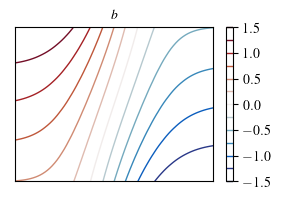

In [11]:
b.change_scales(1)

fig=plt.figure(figsize=(3.2, 2.0))
# plt.contour(y.ravel(), z.ravel(), zeta.allgather_data('g').T, np.arange(-3.0,3.1,0.1), cmap=cmo.balance, norm=colors.CenteredNorm())
plt.contour(y.ravel(), z.ravel(), (b.allgather_data('g')+z).T, 13, cmap=cmo.balance)
# plt.gca().set_aspect('equal')
# plt.xlabel('$y$')
# plt.ylabel('$z$')
plt.xticks([])
plt.yticks([])
plt.title("$b$")
plt.colorbar()
plt.xlim([-2,2])

figname = 'plot/figs/2DFQGpl_bt0'
figname = figname.replace(".", "d" ); figname = figname+'.pdf'
# plt.savefig(figname, bbox_inches='tight')

In [12]:
b.allgather_data('g')[0,:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

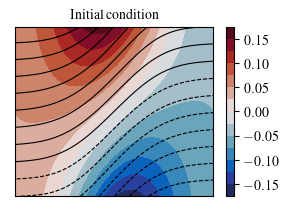

In [13]:
b.change_scales(1)
u.change_scales(1)

fig=plt.figure(figsize=(3.2, 2.2))
plt.contour(y.ravel(), z.ravel(), (Ro*b.allgather_data('g')+z).T, np.arange(-3,3.3,0.1), colors='black', linewidths=0.8)
plt.contourf(y.ravel(), z.ravel(), Ro*u.allgather_data('g').T, 15, cmap=cmo.balance)

plt.xticks([])
plt.yticks([])
# plt.title("Initial Condition")
plt.colorbar()
plt.xlim([-2,2])
plt.title("Initial condition")

figname = 'plot/figs/2DFSemiu_t0'
figname = figname.replace(".", "d" ); figname = figname+'.pdf'
plt.savefig(figname, bbox_inches='tight')